In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import podpac
from podpac import Node
from podpac import alglib
import traitlets as tl
import logging
import time
import inspect
logger = logging.getLogger('podpac')
logger.setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# Set up the source data Nodes

In [3]:
node = podpac.data.Zarr(
#     source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    source=r'C:\SMAP.zarr',
    time_key='time',
    data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
node

<Zarr(source='C:\\SMAP.zarr', interpolation='nearest', data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture')>

In [4]:
node_poros = podpac.data.Zarr(
#     source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    source=r'C:\SMAP_PROPS.zarr',
    data_key='Land-Model-Constants_Data/clsm_poros',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
node_poros

<Zarr(source='C:\\SMAP_PROPS.zarr', interpolation='nearest', data_key='Land-Model-Constants_Data/clsm_poros')>

In [5]:
node.native_coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[-84.65642547607422, 84.65641784667969], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.95314025878906, 179.95314025878906], N[3856], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

## Test source data Node

DEBUG:podpac.core.data.datasource:Evaluating Zarr data source


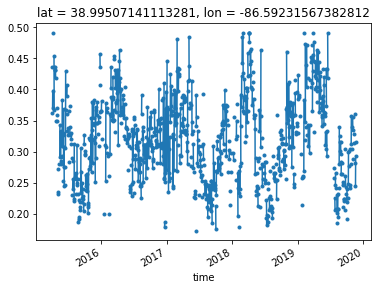

In [6]:
o = node.eval(node.native_coordinates[300, 1000, :])
o[:, :, :].plot(marker='.')

# Create Coordinates for testing

In [7]:
coords = node.native_coordinates[300:302, 1000:1002, :]
coords

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

# Set up Algorithm Node to fit a beta function to the input data for each day of the year

In [6]:
sb = alglib.climatology.BetaFitDayOfYear(source=node, percentiles=[0.3, 0.2, 0.1, 0.05, 0.02], window=44, scale_max=node_poros,
                                         scale_float=[0, 1])

# Test Algorithm Node locally

In [9]:
s = time.time()
o3 = sb.eval(coords)
tot_time = time.time() - s
print("took {}".format(tot_time))

DEBUG:podpac.core.data.datasource:Evaluating Zarr data source
DEBUG:podpac.core.data.datasource:Evaluating Zarr data source
DEBUG:podpac.core.algorithm.stats:scale_min: 0
scale_max: <xarray.UnitsDataArray (lat: 2, lon: 2)>
array([[0.46200001, 0.4508    ],
       [0.46200001, 0.46200001]])
Coordinates:
  * lat      (lat) float64 39.0 38.9
  * lon      (lon) float64 -86.59 -86.5
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001B4B8D2B088>
    crs:          EPSG:4326
c:\repositories\pipeline\podpac\podpac\core\algorithm\stats.py:1021: RuntimeWarning: invalid value encountered in less
  source.data[(source.data < 0) | (source.data > 1)] = np.nan
c:\repositories\pipeline\podpac\podpac\core\algorithm\stats.py:1021: RuntimeWarning: invalid value encountered in greater
  source.data[(source.data < 0) | (source.data > 1)] = np.nan
DEBUG:podpac.core.algorithm.stats:Working on doy 1 (1/366)
DEBUG:podpac.core.algorithm.stats:Working on doy 2 (2/366)
DEBUG:podpac.core.algori

took 17.031320571899414


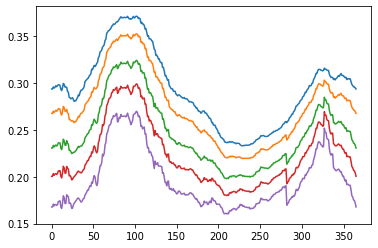

In [10]:
plot((o3)[0, 0, :, 2:].data)

# Setup parallel computation

In [9]:
# Decide chunk size based on 1000 workers and 30% land cover on earth
chunk_size = np.floor(np.sqrt((node.native_coordinates.shape[0] * node.native_coordinates.shape[1] * 0.3)  // 1000))
chunk_size

43.0

In [10]:
chunk_size**2*tot_time/4/60  # Expected time to completion in minutes

NameError: name 'tot_time' is not defined

In [11]:
# Too long for 15 minute lambda function, so we'll need multiple 1000's of workers

In [12]:
coords['time'].size

1759

In [7]:
node_p = podpac.managers.Process(source=sb)
# node_p = podpac.managers.Lambda(source=sb)

In [17]:
o = node_p.eval(coords)

DEBUG:podpac.core.managers.multi_process:Starting process.
DEBUG:podpac.core.managers.multi_process:Retrieving data from queue.
DEBUG:podpac.core.managers.multi_process:Joining.
DEBUG:podpac.core.managers.multi_process:Closing.


In [20]:
o

<xarray.UnitsDataArray (lat: 2, lon: 2, time: 366, output: 7)>
array([[[[5.89634595, 2.45364362, 0.29351688, ..., 0.23058303,
          0.2004137 , 0.16776138],
         [5.89634595, 2.45364362, 0.29351688, ..., 0.23058303,
          0.2004137 , 0.16776138],
         [6.01771813, 2.45838525, 0.29575982, ..., 0.23335983,
          0.20334881, 0.17077883],
         ...,
         [6.38395713, 2.62582305, 0.29581925, ..., 0.23545644,
          0.20635922, 0.17465731],
         [6.23295221, 2.58581341, 0.29459059, ..., 0.23350627,
          0.20412531, 0.17218618],
         [5.89634595, 2.45364362, 0.29351688, ..., 0.23058303,
          0.2004137 , 0.16776138]],

        [[6.092429  , 2.50356286, 0.28814076, ..., 0.2277115 ,
          0.19864879, 0.16709019],
         [6.092429  , 2.50356286, 0.28814076, ..., 0.2277115 ,
          0.19864879, 0.16709019],
         [6.14827645, 2.49223021, 0.2896742 , ..., 0.22943406,
          0.20040298, 0.1688303 ],
         ...,
         [6.59095558, 2.64510891, 0.2915825 , ..., 0.23351727,
          0.20540769, 0.1746679 ],
         [6.39878624, 2.61696297, 0.28926635, ..., 0.23039673,
          0.20199785, 0.17104086],
         [6.092429  , 2.50356286, 0.28814076, ..., 0.2277115 ,
          0.19864879, 0.16709019]]],


       [[[5.26829321, 2.16075641, 0.29352828, ..., 0.22645808,
          0.1944712 , 0.16014732],
         [5.26829321, 2.16075641, 0.29352828, ..., 0.22645808,
          0.1944712 , 0.16014732],
         [5.27352094, 2.12967844, 0.29521165, ..., 0.2280233 ,
          0.19591696, 0.16142683],
         ...,
         [5.69264536, 2.33156277, 0.29473959, ..., 0.23043905,
          0.1996196 , 0.16632403],
         [5.55960781, 2.30348303, 0.29317833, ..., 0.22815138,
          0.19707058, 0.16358346],
         [5.26829321, 2.16075641, 0.29352828, ..., 0.22645808,
          0.1944712 , 0.16014732]],

        [[6.90207403, 3.32419717, 0.27993426, ..., 0.22344981,
          0.19657506, 0.16741264],
         [6.90207403, 3.32419717, 0.27993426, ..., 0.22344981,
          0.19657506, 0.16741264],
         [7.01564266, 3.32672256, 0.28185528, ..., 0.2257091 ,
          0.19893077, 0.16981582],
         ...,
         [7.28939861, 3.43832873, 0.28295849, ..., 0.2278977 ,
          0.20157508, 0.17287753],
         [7.12122375, 3.39915628, 0.2813485 , ..., 0.22570933,
          0.19917146, 0.1703011 ],
         [6.90207403, 3.32419717, 0.27993426, ..., 0.22344981,
          0.19657506, 0.16741264]]]])
Coordinates:
  * lat      (lat) float64 39.0 38.9
  * lon      (lon) float64 -86.59 -86.5
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 ... 363.0 364.0 365.0 366.0
  * output   (output) <U2 'a' 'b' 'd0' 'd1' 'd2' 'd3' 'd4'
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001B4B9E4DE48>
    crs:          EPSG:4326

In [9]:
coords_mp = node.native_coordinates[300:306, 1000:1006, :]
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [10]:
node_mp = podpac.managers.ParallelOutputZarr(
    source=node_p, 
    number_of_workers=4, 
#     number_of_workers=1000, 
    chunks={'lat': 2, 'lon': 2},
    zarr_file=r'C:\SMAP_CATS.zarr', init_file_mode='a',
    zarr_chunks={'lat': 2, 'lon': 2, 'time': 128},
    zarr_shape={'lat': coords_mp['lat'].size, 'lon': coords_mp['lon'].size, 'time': 366},
    zarr_coordinates=podpac.Coordinates([podpac.crange(1, 366, 1, 'time')]),
    skip_existing=True,
    list_dir=True
)

# Test parallel computation locally using multiple processors

In [11]:
# output = dict(format='zarr_part', 
#               format_kwargs=dict(part=[[0, 2, 1], [0, 2, 1], [0, 366, 1]],
#              source=node_mp.zarr_file,mode="a"))
# o.to_format(output['format'], **output['format_kwargs'])

In [12]:
o_mp = node_mp.eval(coords_mp)

DEBUG:podpac.core.managers.parallel:Creating Zarr file.
DEBUG:podpac.core.managers.parallel:Starting parallel eval.
DEBUG:podpac.core.managers.parallel:Added 0 to worker pool
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(0, 2, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']
DEBUG:podpac.core.managers.parallel:Added 1 to worker pool
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(2, 4, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.40560913085938, -86.31224822998047], N[2

In [23]:
# Check the results
cats = podpac.data.Zarr(
    source=r'C:\SMAP_CATS.zarr',
)
cats

<Zarr(source='C:\\SMAP_CATS.zarr', interpolation='nearest')>

In [24]:
d0 = cats.dataset['d0'][5, 5, :]

In [25]:
cats.dataset['d0'].shape

(6, 6, 366)

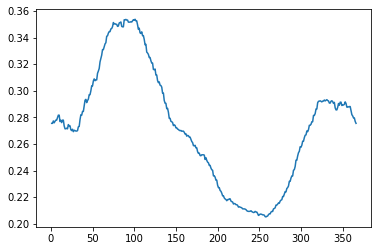

In [26]:
plot(cats.dataset['time'], d0.reshape(-1, 366).T)
pass

In [27]:
list(cats.dataset.keys())

['a', 'b', 'd0', 'd1', 'd2', 'd3', 'd4', 'lat', 'lon', 'time']

In [28]:
cats.native_coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[1.0, 366.0], N[366], ctype['midpoint']

# Test on AWS

In [13]:
settings = {
    "FUNCTION_NAME": "podpac-drought-monitor-lambda-compute-stats",
    "S3_BUCKET_NAME": "podpac-drought-monitor-s3",
    "FUNCTION_ROLE_NAME": "podpac-drought-monitor-role",
    "MULTITHREADING": True,
    "N_THREADS": 64,
    "AWS_ACCESS_KEY_ID": podpac.settings["AWS_ACCESS_KEY_ID"],
    "AWS_SECRET_ACCESS_KEY": podpac.settings["AWS_SECRET_ACCESS_KEY"],
    "AWS_REGION_NAME": podpac.settings["AWS_REGION_NAME"],
    "AWS_BUDGET_AMOUNT": 100,
    "AWS_BUDGET_EMAIL": podpac.settings["AWS_BUDGET_EMAIL"],
    "FUNCTION_DEPENDENCIES_KEY": "podpac_deps.zip",
}
podpac.settings.update(settings)
# settings

In [14]:
node = podpac.data.Zarr(
    source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    time_key='time',
    data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
# node

In [15]:
node_poros = podpac.data.Zarr(
    source=r's3://podpac-drought-monitor-s3/SMAP_PROPS.zarr',
    data_key='Land-Model-Constants_Data/clsm_poros',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
# node_poros

In [16]:
sb = alglib.climatology.BetaFitDayOfYear(source=node, percentiles=[0.3, 0.2, 0.1, 0.05, 0.02], window=44, scale_max=node_poros,
                                         scale_float=[0, 1])

In [17]:
coords = node.native_coordinates[300:302, 1000:1002, :]
coords

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [18]:
coords_mp = node.native_coordinates[300:306, 1000:1006, :]
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [19]:
node_p = podpac.managers.Lambda(
    source=sb,
    eval_settings=settings,
    eval_timeout=60*15,
)

In [20]:
node_p.get_budget()
node_p.describe()

DEBUG:podpac.core.managers.aws:Getting budget with name podpac-drought-monitor-lambda-compute-stats-budget



Lambda Node (staged)
    Function
        Name: podpac-drought-monitor-lambda-compute-stats
        Description: PODPAC Lambda Function (https://podpac.org)
        ARN: None
        Triggers: ['eval']
        Handler: handler.handler
        Environment Variables: {}
        Timeout: 600 seconds
        Memory: 2048 MB
        Tags: {}
        Source Dist: s3://podpac-dist/dev/podpac_dist.zip
        Source Dependencies: s3://podpac-dist/dev/podpac_deps.zip
        Last Modified: None
        Version: None
        Restrict Evaluation: []

    S3
        Bucket: podpac-drought-monitor-s3
        Tags: {}
        Input Folder: input/
        Output Folder: output/

    Role
        Name: podpac-drought-monitor-role
        Description: PODPAC Lambda Role
        ARN: None
        Policy Document: {'Version': '2012-10-17', 'Statement': [{'Effect': 'Allow', 'Action': ['s3:PutObject', 's3:GetObject', 's3:DeleteObject', 's3:ReplicateObject', 's3:ListBucket', 's3:ListMultipartUploadParts', 

In [37]:
# o = podpac.Node.from_json(node_p.json).eval(coords)  #Check! Works well

In [45]:
start = time.time()
i = 2
coords = node.native_coordinates[300:302 + i, 1000:1002 + i, :]
o = node_p.eval(coords)
tot_time = time.time() - start
print(tot_time)
o.shape

DEBUG:podpac.core.managers.aws:Evaluating pipeline via invoke synchronously
DEBUG:podpac.core.managers.aws:Received response from lambda function


110.16053366661072


(4, 4, 366, 7)

In [46]:
np.sqrt(60*15 / (72 / i **2))

7.0710678118654755

In [47]:
o

<xarray.UnitsDataArray (lat: 4, lon: 4, time: 366, output: 7)>
array([[[[ 5.89634595,  2.45364362,  0.29351688, ...,  0.23058303,
           0.2004137 ,  0.16776138],
         [ 5.89634595,  2.45364362,  0.29351688, ...,  0.23058303,
           0.2004137 ,  0.16776138],
         [ 6.01771813,  2.45838525,  0.29575982, ...,  0.23335983,
           0.20334881,  0.17077883],
         ...,
         [ 6.38395713,  2.62582305,  0.29581925, ...,  0.23545644,
           0.20635922,  0.17465731],
         [ 6.23295221,  2.58581341,  0.29459059, ...,  0.23350627,
           0.20412531,  0.17218618],
         [ 5.89634595,  2.45364362,  0.29351688, ...,  0.23058303,
           0.2004137 ,  0.16776138]],

        [[ 6.092429  ,  2.50356286,  0.28814076, ...,  0.2277115 ,
           0.19864879,  0.16709019],
         [ 6.092429  ,  2.50356286,  0.28814076, ...,  0.2277115 ,
           0.19864879,  0.16709019],
         [ 6.14827645,  2.49223021,  0.2896742 , ...,  0.22943406,
           0.20040298,  0.1688303 ],
         ...,
         [ 6.59095558,  2.64510891,  0.2915825 , ...,  0.23351727,
           0.20540769,  0.1746679 ],
         [ 6.39878624,  2.61696297,  0.28926635, ...,  0.23039673,
           0.20199785,  0.17104086],
         [ 6.092429  ,  2.50356286,  0.28814076, ...,  0.2277115 ,
           0.19864879,  0.16709019]],

        [[ 4.44822171,  1.10623371,  0.29939951, ...,  0.23210352,
           0.1980107 ,  0.16068085],
         [ 4.44822171,  1.10623371,  0.29939951, ...,  0.23210352,
           0.1980107 ,  0.16068085],
         [ 4.53876389,  1.08636549,  0.30265607, ...,  0.23612924,
           0.20218782,  0.16483547],
         ...,
         [ 4.470492  ,  1.03772472,  0.30509681, ...,  0.23795738,
           0.20355356,  0.16565343],
         [ 4.56530031,  1.11037719,  0.30136476, ...,  0.23507854,
           0.20133837,  0.16423456],
         [ 4.44822171,  1.10623371,  0.29939951, ...,  0.23210352,
           0.1980107 ,  0.16068085]],

        [[ 4.50851468,  1.10800163,  0.30045013, ...,  0.23367726,
           0.19976419,  0.1625463 ],
         [ 4.50851468,  1.10800163,  0.30045013, ...,  0.23367726,
           0.19976419,  0.1625463 ],
         [ 4.74023352,  1.10520582,  0.30496493, ...,  0.24013814,
           0.20686906,  0.17003147],
         ...,
         [ 4.09896953,  0.94510912,  0.30536476, ...,  0.2346324 ,
           0.19848324,  0.15899261],
         [ 4.3428374 ,  1.05527514,  0.30122333, ...,  0.23293209,
           0.19824374,  0.16028264],
         [ 4.50851468,  1.10800163,  0.30045013, ...,  0.23367726,
           0.19976419,  0.1625463 ]]],


       [[[ 5.26829321,  2.16075641,  0.29352828, ...,  0.22645808,
           0.1944712 ,  0.16014732],
         [ 5.26829321,  2.16075641,  0.29352828, ...,  0.22645808,
           0.1944712 ,  0.16014732],
         [ 5.27352094,  2.12967844,  0.29521165, ...,  0.2280233 ,
           0.19591696,  0.16142683],
         ...,
         [ 5.69264536,  2.33156277,  0.29473959, ...,  0.23043905,
           0.1996196 ,  0.16632403],
         [ 5.55960781,  2.30348303,  0.29317833, ...,  0.22815138,
           0.19707058,  0.16358346],
         [ 5.26829321,  2.16075641,  0.29352828, ...,  0.22645808,
           0.1944712 ,  0.16014732]],

        [[ 6.90207403,  3.32419717,  0.27993426, ...,  0.22344981,
           0.19657506,  0.16741264],
         [ 6.90207403,  3.32419717,  0.27993426, ...,  0.22344981,
           0.19657506,  0.16741264],
         [ 7.01564266,  3.32672256,  0.28185528, ...,  0.2257091 ,
           0.19893077,  0.16981582],
         ...,
         [ 7.28939861,  3.43832873,  0.28295849, ...,  0.2278977 ,
           0.20157508,  0.17287753],
         [ 7.12122375,  3.39915628,  0.2813485 , ...,  0.22570933,
           0.19917146,  0.1703011 ],
         [ 6.90207403,  3.32419717,  0.27993426, ...,  0.22344981,
           0.19657506,  0.16741264]],

        [[ 5.77502159,  2.32017971,  0.29698874, ...,  0.23302013,
           0.20226433,  0.16

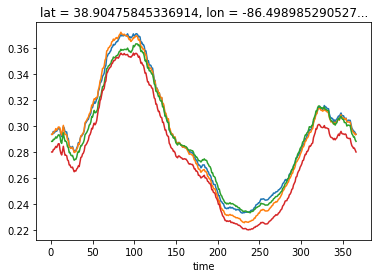

In [48]:
o[0, 0, :, 2].plot()
o[1, 0, :, 2].plot()
o[0, 1, :, 2].plot()
o[1, 1, :, 2].plot()

# Test on AWS in parallel

In [11]:
node_p = podpac.managers.Lambda(
    source=sb,
    eval_settings=settings,
    eval_timeout=1.25,  # This is dependent on my internet connection and AWS' response time.
    download_result=True  # This is the default anyway...
)

In [12]:
# Test Async Exception -- Trying to figure out what the exception should be
# import botocore
# for i in range(6):
#     print(i)
#     try:
#         o=node_p.eval(coords)
#     except botocore.exceptions.ReadTimeoutError:
#         pass

In [13]:
coords_mp = node.native_coordinates[300:306, 1000:1006, :]
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [14]:
node_mp = podpac.core.managers.parallel.ParallelAsyncOutputZarr(
    source=node_p, 
    number_of_workers=2, 
    chunks={'lat': 2, 'lon': 2},
    zarr_file=r's3://podpac-drought-monitor-s3/SMAP_CATS_TEST.zarr', init_file_mode='a',
    zarr_chunks={'lat': 2, 'lon': 2, 'time': 128},
    zarr_shape={'lat': coords_mp['lat'].size, 'lon': coords_mp['lon'].size, 'time': 366},
    zarr_coordinates=podpac.Coordinates([podpac.crange(1, 366, 1, 'time')]),
    skip_existing=True,
    list_dir=True
)

In [15]:
o_mp = node_mp.eval(coords_mp)

DEBUG:podpac.core.managers.parallel:Creating Zarr file.
DEBUG:podpac.core.managers.parallel:Starting parallel eval.
DEBUG:podpac.core.managers.parallel:Added 0 to worker pool
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(0, 2, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.49898529052734], N[2], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']
DEBUG:podpac.core.managers.parallel:Added 1 to worker pool
DEBUG:podpac.core.managers.parallel:Node eval with coords: (slice(0, 2, None), slice(2, 4, None), slice(0, 1759, None)), Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.90475845336914, 38.99507141113281], N[2], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.40560913085938, -86.31224822998047], N[2

I somehow have to clear the Zarr cache but I haven't figured out how to do that... 
so i restart to check the results

In [3]:
# Check the results
cats = podpac.data.Zarr(
    # For some reason I only get Nans for this, maybe a permission error?
    source=r's3://podpac-drought-monitor-s3/SMAP_CATS_TEST.zarr',  
#     source=r'C:\SMAP_CATS_TEST.zarr',  # I downloaded this to check, and the data is just fine
    file_mode='a'
)
cats

<Zarr(source='s3://podpac-drought-monitor-s3/SMAP_CATS_TEST.zarr', interpolation='nearest')>

In [4]:
cats.available_data_keys

['a', 'b', 'd0', 'd1', 'd2', 'd3', 'd4']

In [5]:
d0 = cats.dataset['d0'][:6, :6, :]

In [6]:
cats.dataset['d0'].shape

(6, 6, 366)

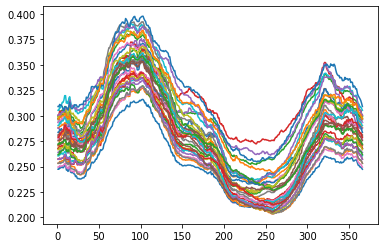

In [7]:
plot(cats.dataset['time'], d0.reshape(-1, 366).T)
pass

In [8]:
np.nanmax(d0)

0.3978528286574542

In [9]:
list(cats.dataset.keys())

['a', 'b', 'd0', 'd1', 'd2', 'd3', 'd4', 'lat', 'lon', 'time']

In [10]:
cats.native_coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.544620513916016, 38.99507141113281], N[6], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-86.59231567382812, -86.12550354003906], N[6], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[1.0, 366.0], N[366], ctype['midpoint']

In [20]:
node_p.get_budget()

DEBUG:podpac.core.managers.aws:Getting budget with name podpac-drought-monitor-lambda-compute-stats-budget


{'BudgetName': 'podpac-drought-monitor-lambda-compute-stats-budget',
 'BudgetLimit': {'Amount': '500.0', 'Unit': 'USD'},
 'CostFilters': {'Service': ['AWS Lambda'],
  'TagKeyValue': ['user:_podpac_resource_hash$013285c69752c615135a48f1f1362cae']},
 'CostTypes': {'IncludeTax': True,
  'IncludeSubscription': True,
  'UseBlended': False,
  'IncludeRefund': False,
  'IncludeCredit': False,
  'IncludeUpfront': True,
  'IncludeRecurring': True,
  'IncludeOtherSubscription': True,
  'IncludeSupport': True,
  'IncludeDiscount': True,
  'UseAmortized': False},
 'TimeUnit': 'MONTHLY',
 'TimePeriod': {'Start': datetime.datetime(2020, 3, 31, 20, 0, tzinfo=tzlocal()),
  'End': datetime.datetime(2087, 6, 14, 20, 0, tzinfo=tzlocal())},
 'CalculatedSpend': {'ActualSpend': {'Amount': '86.098', 'Unit': 'USD'}},
 'BudgetType': 'COST',
 'LastUpdatedTime': datetime.datetime(2020, 4, 13, 12, 14, 42, 580000, tzinfo=tzlocal())}

# Do the computation for the whole world!
Delete the SMAP_CATS zarr file that exists on S3 before continuing here.

I found that Jupyter would hang because the log file gets too big. so I run a similar script from the commandline instead. 

In [23]:
%pylab widget

Populating the interactive namespace from numpy and matplotlib


In [2]:
import podpac
from podpac import Node
from podpac import alglib
import traitlets as tl
import logging
import time
import inspect
logger = logging.getLogger('podpac')
logger.setLevel(logging.INFO)

In [3]:
from podpac.utils import create_logfile

In [4]:
create_logfile(r'D:\smap_cats_compute_4.log')

INFO:podpac.core.utils:Logging to file D:\smap_cats_compute_4.log


(<Logger podpac (INFO)>,
 <FileHandler D:\smap_cats_compute_4.log (NOTSET)>,
 <logging.Formatter at 0x1d4d643fc48>)

In [3]:
settings = {
    "FUNCTION_NAME": "podpac-drought-monitor-lambda-compute-stats",
    "S3_BUCKET_NAME": "podpac-drought-monitor-s3",
    "FUNCTION_ROLE_NAME": "podpac-drought-monitor-role",
    "MULTITHREADING": True,
    "N_THREADS": 64,
    "AWS_ACCESS_KEY_ID": podpac.settings["AWS_ACCESS_KEY_ID"],
    "AWS_SECRET_ACCESS_KEY": podpac.settings["AWS_SECRET_ACCESS_KEY"],
    "AWS_REGION_NAME": podpac.settings["AWS_REGION_NAME"],
    "AWS_BUDGET_AMOUNT": 100,
    "AWS_BUDGET_EMAIL": podpac.settings["AWS_BUDGET_EMAIL"],
    "FUNCTION_DEPENDENCIES_KEY": "podpac_deps.zip",
}
podpac.settings.update(settings)
# settings

In [6]:
N_WORKERS = 100

In [7]:
node = podpac.data.Zarr(
    source='s3://podpac-drought-monitor-s3/SMAP.zarr',
    time_key='time',
    data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True,
)
# node

In [8]:
node_poros = podpac.data.Zarr(
    source=r's3://podpac-drought-monitor-s3/SMAP_PROPS.zarr',
    data_key='Land-Model-Constants_Data/clsm_poros',
    lat_key='lat',
    lon_key='lon',
    nan_vals=[-9999],
    skip_validation=True
)
# node_poros

In [9]:
sb = alglib.climatology.BetaFitDayOfYear(source=node, percentiles=[0.3, 0.2, 0.1, 0.05, 0.02], window=44, scale_max=node_poros,
                                         scale_float=[0, 1])

In [10]:
coords_mp = node.native_coordinates#.select({"lat": [], "lon": []})
coords_mp

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[-84.65642547607422, 84.65641784667969], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.95314025878906, 179.95314025878906], N[3856], ctype['midpoint']
	time: ArrayCoordinates1d(time): Bounds[2015-03-31, 2020-02-29], N[1759], ctype['point']

In [11]:
node_p = podpac.managers.Lambda(
    source=sb,
    eval_settings=settings,
    eval_timeout=1.25
)

In [12]:
node_mp = podpac.core.managers.parallel.ParallelAsyncOutputZarr(
    source=node_p, 
    number_of_workers=N_WORKERS,
    chunks={'lat': 8, 'lon': 8},
    zarr_file=r's3://podpac-drought-monitor-s3/SMAP_CATS.zarr', init_file_mode='a',
    zarr_chunks={'lat': 8, 'lon': 8, 'time': 128},
    zarr_shape={'lat': coords_mp['lat'].size, 'lon': coords_mp['lon'].size, 'time': 366},
    zarr_coordinates=podpac.Coordinates([podpac.crange(1, 366, 1, 'time')]),
    skip_existing=True,
    aws_config_kwargs=dict(max_pool_connections=N_WORKERS*10),  # This is needed to avoid a warning about the number of open connections
    start_i = 20100  # I was developing the software as I was doing this computation, so I made improvements along the way and did not want to start over
)
node_mp

<ParallelAsyncOutputZarr(source=Lambda (staged)
	Name: podpac-drought-monitor-lambda-compute-stats
	Source: BetaFitDayOfYear
	Bucket: podpac-drought-monitor-s3
	Triggers: ['eval']
	Role: podpac-drought-monitor-role
, number_of_workers=100, chunks={'lat': 8, 'lon': 8})>

In [ ]:
o_mp = node_mp.eval(coords_mp)

INFO:podpac.core.managers.parallel:Submitting source 20104
INFO:podpac.core.managers.parallel:Submitting source 20117
INFO:podpac.core.managers.parallel:Submitting source 20100
INFO:podpac.core.managers.parallel:Submitting source 20112
INFO:podpac.core.managers.parallel:Submitting source 20113
INFO:podpac.core.managers.parallel:Submitting source 20118
INFO:podpac.core.managers.parallel:Submitting source 20103
INFO:podpac.core.managers.parallel:Submitting source 20105
INFO:podpac.core.managers.parallel:Submitting source 20120
INFO:podpac.core.managers.parallel:Submitting source 20200
INFO:podpac.core.managers.parallel:Submitting source 20201
INFO:podpac.core.managers.parallel:Submitting source 20109
INFO:podpac.core.managers.parallel:Submitting source 20102
INFO:podpac.core.managers.parallel:Submitting source 20115
INFO:podpac.core.managers.parallel:Submitting source 20125
INFO:podpac.core.managers.parallel:Submitting source 20114
INFO:podpac.core.managers.parallel:Submitting source 201

In [4]:
# Check the results
cats = podpac.data.Zarr(
    source=r's3://podpac-drought-monitor-s3/SMAP_CATS.zarr',
)
cats

<Zarr(source='s3://podpac-drought-monitor-s3/SMAP_CATS.zarr', interpolation='nearest')>

In [5]:
d0 = cats.dataset['d0'][:, :, 128]

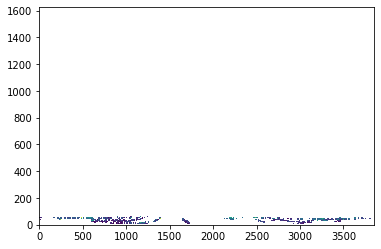

In [6]:
pcolormesh(d0)